In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os

drive_path = '/content/drive/MyDrive/BERT_for_Disaster_Classification'
print(os.listdir(drive_path))


['Disaster_Tweets_Project', 'BERT_Models', 'Dataset2_not_used_yet', 'Dataset1_used']


In [ ]:
db_path = '/content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project/combined_incident_tweets.db'

In [ ]:
import sqlite3
import pandas as pd


conn = sqlite3.connect(db_path)

# Load the data from the 'entries' table into a DataFrame
df = pd.read_sql('SELECT * FROM entries', conn)

In [ ]:
df

,id,text,relevance
0,'497086296385675264',<HASHTAG> ebola symptoms. early treatment mean...,1
1,'497086297475805184',thinking about telling leadership to make indi...,1
2,'497086300781309952',"we know people are contracting the disease, an...",1
3,'497086305671864321',this is <USER> nurse <HASHTAG> <NUMBER> is at ...,1
4,'497086306443202560',you asked questions about ebola â€” and we hav...,1
...,...,...,...
163713,780474194983346176,will it be easy? nope. will it be worth it? ab...,0
163714,297053317027213312,<USER> all is cool here thank god!,0
163715,1045486858694799360,<USER> she's not adding up. she said she was <...,0
163716,240096723932950528,"just listening to dave days' covers/originals,...",0


In [ ]:
#!pip install torch

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU %s" % torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU :-(")


Using CPU :-(


In [ ]:
#!pip install transformers

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
text = df["text"].values
labels = df["relevance"].values

#sampled_df = df.groupby('relevance').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)

# Access the sampled text and labels
##text = sampled_df["text"].values
##labels = sampled_df["relevance"].values


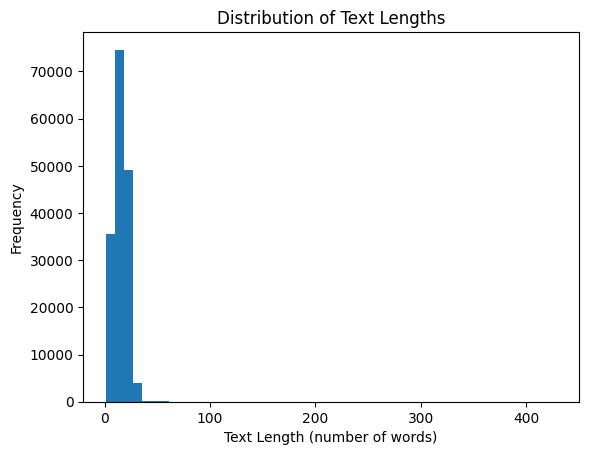

In [ ]:
import matplotlib.pyplot as plt

# Assuming df['text'] contains your texts
text_lengths = df['text'].apply(lambda x: len(x.split()))  # Using word count for length
plt.hist(text_lengths, bins=50)  # Adjust bins as necessary
plt.xlabel('Text Length (number of words)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [ ]:
percentiles = text_lengths.quantile([0.5, 0.75, 0.9])
print(percentiles)

0.50    15.0
0.75    20.0
0.90    23.0
Name: text, dtype: float64


In [ ]:
#max_len = max([len(tokenizer.encode(t, add_special_tokens=True)) for t in text])
#max_len

In [ ]:
input_ids = []
attention_masks = []

for t in text:
    encoded_dict = tokenizer.encode_plus(
                        t,
                        add_special_tokens = True,    # '[CLS]' and '[SEP]'
                        max_length = 64,
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,  # Generate attention masks
                        return_tensors = 'pt',         # PyTorch tensors as output
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

In [ ]:
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [ ]:
print(text[0])
print(tokenizer.tokenize(text[0]))
print(input_ids[0])

<HASHTAG> ebola symptoms. early treatment means a much better chance of survival. <HASHTAG> ebolaresponse <URL>
['<', 'hash', '##tag', '>', 'e', '##bola', 'symptoms', '.', 'early', 'treatment', 'means', 'a', 'much', 'better', 'chance', 'of', 'survival', '.', '<', 'hash', '##tag', '>', 'e', '##bola', '##res', '##pon', '##se', '<', 'ur', '##l', '>']
tensor([  101,  1026, 23325, 15900,  1028,  1041, 24290,  8030,  1012,  2220,
         3949,  2965,  1037,  2172,  2488,  3382,  1997,  7691,  1012,  1026,
        23325, 15900,  1028,  1041, 24290,  6072, 26029,  3366,  1026, 24471,
         2140,  1028,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)

In [ ]:
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
# Work reproducibly!
torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(train_size, val_size)

122788 40930


In [ ]:
sample = val_dataset[0]  # This will give you a tuple (input_data, label)
print(sample)

(tensor([  101,  1026, 24471,  2140,  1028,  3731, 20109,  1024,  1999,  1996,
         2227,  1997, 10576,  1010,  4841,  2064,  2424, 15003,  1064,  2899,
         2335,  4279,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), tensor(1))


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32  #32

In [ ]:
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

In [ ]:
val_texts = []
val_labels = []

for i in range(len(val_dataset)):
    input_ids, attention_mask, label = val_dataset[i]

    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    val_texts.append(decoded_text)
    val_labels.append(label.item())

val_df = pd.DataFrame({
    'text': val_texts,
    'label': val_labels
})

print(val_df.head())


                                                text  label
0  < url > boston bombings : in the face of trage...      1
1  our service line is open for your comments, gr...      1
2                           < number > babys < url >      0
3               < user > < hashtag > mecasalu ( rt )      0
4      itsfoodporn : s'mores stuffed cookies < url >      0


In [ ]:
val_df.shape

val_df.to_csv('/content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project/validation_dataset.csv', index=False)
print("Validation dataset saved as 'validation_dataset.csv'.")

Validation dataset saved as 'validation_dataset.csv'.


In [ ]:
# Inspect a sample batch
for batch in validation_dataloader:
    print(batch)
    break  # Only print the first batch for inspection


[tensor([[  101,  1026, 24471,  ...,     0,     0,     0],
        [  101,  2256,  2326,  ...,     0,     0,     0],
        [  101,  1026,  2193,  ...,     0,     0,     0],
        ...,
        [  101,  8222,  1530,  ...,     0,     0,     0],
        [  101,  4121,  4283,  ...,     0,     0,     0],
        [  101, 11333, 17413,  ...,     0,     0,     0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 1, 0])]


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# The model must match the tokenizer!
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, # We only have good or bad.
    output_attentions = False,
    output_hidden_states = False # We don't need embeddings.
)
# Here, you might need to use model.cpu().
#model.cpu()
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Select an optimizer; AdamW is the standard.
optimizer = AdamW(model.parameters(), lr = 2e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Four epochs; this may need to be adjusted.
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
%%time
import random
import numpy as np
from tqdm.auto import trange, tqdm

# Initialize all random number generators (reproducibility).
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Statistics for training.
training_stats = []

for epoch_i in trange(epochs, desc="Epoch"):
    # Accumulated loss for this epoch.
    total_train_loss = 0

    # Set the model to training mode.
    model.train()

    # Train in batches.
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        # Unpack data and convert it to device format.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear gradients.
        model.zero_grad()

        # Forward evaluation (predicting training data).
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Calculate and accumulate loss.
        total_train_loss += res.loss.item()

        # Backward evaluation to determine gradients.
        res.loss.backward()

        # Clip gradients due to exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and learning rate.
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all batches.
    avg_train_loss = total_train_loss / len(train_dataloader)



    # Switch the model to prediction mode.
    model.eval()

    # Tracking variables.
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.
    for batch in tqdm(validation_dataloader, desc="Validation"):
        # Now unpack the validation data.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Backward evaluation is not needed, so no gradients are required.
        with torch.no_grad():
            # Make predictions.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate loss.
        total_eval_loss += res.loss.item()

        # Convert prediction data to CPU format to calculate accuracy.
        logits = res.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Update the total evaluation accuracy (Line added)
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Output overall accuracy for this validation.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    tqdm.write("Accuracy: %f" % avg_val_accuracy)

    # Calculate total loss over all batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    tqdm.write("Validation loss %f" % avg_val_loss)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training loss': avg_train_loss,
            'Validation loss': avg_val_loss,
            'Accuracy': avg_val_accuracy
        }
    )

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/3838 [00:00<?, ?it/s]

Validation:   0%|          | 0/1280 [00:00<?, ?it/s]

Accuracy: 0.982544
Validation loss 0.110529


Training:   0%|          | 0/3838 [00:00<?, ?it/s]

Validation:   0%|          | 0/1280 [00:00<?, ?it/s]

Accuracy: 0.982544
Validation loss 0.110529


Training:   0%|          | 0/3838 [00:00<?, ?it/s]

Validation:   0%|          | 0/1280 [00:00<?, ?it/s]

Accuracy: 0.982544
Validation loss 0.110529


Training:   0%|          | 0/3838 [00:00<?, ?it/s]

Validation:   0%|          | 0/1280 [00:00<?, ?it/s]

Accuracy: 0.982544
Validation loss 0.110529
CPU times: user 1h 6min 56s, sys: 22min 54s, total: 1h 29min 50s
Wall time: 1h 31min 3s


In [ ]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats).set_index("Epoch")
df_stats

,Training loss,Validation loss,Accuracy
Epoch,,,
1,0.005521,0.110529,0.982544
2,0.003396,0.110529,0.982544
3,0.002503,0.110529,0.982544
4,0.005823,0.110529,0.982544


<Axes: xlabel='Epoch'>

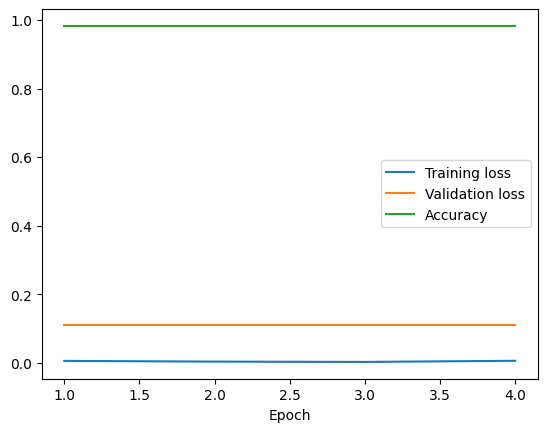

In [ ]:
df_stats.plot()

In [ ]:
model_save_path = '/content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project'

# Save the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project


In [ ]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import torch.nn.functional as F


# Load the model and tokenizer
model_save_path = './my_bert_model'  # Update to your model's path
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# Set the model to evaluation mode
model.eval()

# Input text to test
input_text = "the aftershock destroyed many houses"

# Tokenize and encode the input text
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Make predictions
with torch.no_grad():  # Disable gradient calculations
    outputs = model(**inputs)
    logits = outputs.logits

# Get predicted class (0 or 1)
predicted_class = torch.argmax(logits, dim=1).item()

# Calculate softmax probabilities
probabilities = F.softmax(logits, dim=1)

# Get the confidence for the predicted class
confidence = probabilities[0][predicted_class].item()

# Display the result
print(f"Input text: {input_text}")
print(f"Predicted class: {predicted_class}")
print(f"Confidence for class {predicted_class}: {confidence:.4f}")



Input text: the aftershock did not destroy many houses
Predicted class: 1
Confidence for class 1: 0.9996


In [ ]:
import sqlite3
import pandas as pd


conn = sqlite3.connect(db_path)

# Load the data from the 'entries' table into a DataFrame
df = pd.read_sql('SELECT * FROM entries', conn)
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU %s" % torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU :-(")
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
text = df["text"].values
labels = df["relevance"].values

input_ids = []
attention_masks = []

for t in text:
    encoded_dict = tokenizer.encode_plus(
                        t,
                        add_special_tokens = True,    # '[CLS]' and '[SEP]'
                        max_length = 64,
                        truncation = True,
                        padding='max_length',
                        return_attention_mask = True,  # Generate attention masks
                        return_tensors = 'pt',         # PyTorch tensors as output
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
# Work reproducibly!
torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(train_size, val_size)
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32  #32
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)
from transformers import BertForSequenceClassification, AdamW, BertConfig

# The model must match the tokenizer!
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, # We only have good or bad.
    output_attentions = False,
    output_hidden_states = False # We don't need embeddings.
)
# Here, you might need to use model.cpu().
#model.cpu()
model.to(device)
# Select an optimizer; AdamW is the standard.
optimizer = AdamW(model.parameters(), lr = 2e-5)
from transformers import get_linear_schedule_with_warmup

# Four epochs; this may need to be adjusted.
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
%%time
import random
import numpy as np
from tqdm.auto import trange, tqdm

# Initialize all random number generators (reproducibility).
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Statistics for training.
training_stats = []

for epoch_i in trange(epochs, desc="Epoch"):
    # Accumulated loss for this epoch.
    total_train_loss = 0

    # Set the model to training mode.
    model.train()

    # Train in batches.
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        # Unpack data and convert it to device format.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear gradients.
        model.zero_grad()

        # Forward evaluation (predicting training data).
        res = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Calculate and accumulate loss.
        total_train_loss += res.loss.item()

        # Backward evaluation to determine gradients.
        res.loss.backward()

        # Clip gradients due to exploding gradients.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and learning rate.
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all batches.
    avg_train_loss = total_train_loss / len(train_dataloader)



    # Switch the model to prediction mode.
    model.eval()

    # Tracking variables.
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.
    for batch in tqdm(validation_dataloader, desc="Validation"):
        # Now unpack the validation data.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Backward evaluation is not needed, so no gradients are required.
        with torch.no_grad():
            # Make predictions.
            res = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate loss.
        total_eval_loss += res.loss.item()

        # Convert prediction data to CPU format to calculate accuracy.
        logits = res.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Update the total evaluation accuracy (Line added)
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Output overall accuracy for this validation.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    tqdm.write("Accuracy: %f" % avg_val_accuracy)

    # Calculate total loss over all batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    tqdm.write("Validation loss %f" % avg_val_loss)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training loss': avg_train_loss,
            'Validation loss': avg_val_loss,
            'Accuracy': avg_val_accuracy
        }
    )
model_save_path = '/content/drive/MyDrive/BERT_for_Disaster_Classification/Disaster_Tweets_Project'

# Save the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import torch.nn.functional as F


# Load the model and tokenizer
model_save_path = './my_bert_model'  # Update to your model's path
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

# Set the model to evaluation mode
model.eval()

# Input text to test
input_text = "the aftershock destroyed many houses"

# Tokenize and encode the input text
inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Make predictions
with torch.no_grad():  # Disable gradient calculations
    outputs = model(**inputs)
    logits = outputs.logits

# Get predicted class (0 or 1)
predicted_class = torch.argmax(logits, dim=1).item()

# Calculate softmax probabilities
probabilities = F.softmax(logits, dim=1)

# Get the confidence for the predicted class
confidence = probabilities[0][predicted_class].item()

# Display the result
print(f"Input text: {input_text}")
print(f"Predicted class: {predicted_class}")
print(f"Confidence for class {predicted_class}: {confidence:.4f}")

